## Notebook to handle NFI data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
from torch.utils.data import TensorDataset, DataLoader

path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
path_nfi_full = '/home/tplas/data/gis/National_Forest_Inventory_Woodland_England_2020/National_Forest_Inventory_Woodland_England_2020.shp'

In [4]:
pols_nfi = lca.load_pols(path_nfi_full)
print(f'Loaded {len(pols_nfi)} polygons from {path_nfi_full}')

Loaded 355973 polygons from /home/tplas/data/gis/National_Forest_Inventory_Woodland_England_2020/National_Forest_Inventory_Woodland_England_2020.shp


In [5]:
outline_pd = lca.load_pols(path_dict['pd_outline'])
outline_pd = outline_pd.iloc[0]['geometry']

In [6]:
df_pols_nfi_pd = pols_nfi.intersection(outline_pd)

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/pygeos/set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


In [7]:
## Find non empty polygons in pd series:
inds_inside_pd = df_pols_nfi_pd.area > 0
df_nfi_pd = pols_nfi[inds_inside_pd]
df_nfi_pd = df_nfi_pd.reset_index(drop=True)
# df_pols_nfi_pd = df_pols_nfi_pd.reset_index(drop=True)
print(f'Found {np.sum(inds_inside_pd)} polygons in PD')

Found 3018 polygons in PD


In [8]:
print(df_nfi_pd['IFT_IOA'].unique()) # leaving out young trees because can be any category 

['Bare area' 'Grassland' 'Quarry' 'Urban' 'Road' 'Other vegetation'
 'Open water' 'Assumed woodland' 'Broadleaved' 'Conifer' 'Felled'
 'Ground prep' 'Low density' 'Mixed mainly broadleaved'
 'Mixed mainly conifer' 'Young trees' 'Coppice' 'Shrub' 'Windblow'
 'Uncertain']


In [9]:
use_clear_classes_only = False

if use_clear_classes_only:
    mapping_dict_nfi = {'Broadleaved': 'C1', 
                        'Conifer': 'C2',
                        'Felled': 'C5',
                        'Mixed mainly broadleaved': 'C3',
                        'Mixed mainly conifer': 'C3',
                        'Shrub': 'C4',
                        'Low density': 'C4'
                        # 'Young trees': 'C5'  # leaving out young trees because can be any category 
                        }

    dict_label_to_ind = {'C1' : 1, 'C2' : 2, 'C3' : 3, 'C4' : 4, 'C5' : 5}
else:
    mapping_dict_nfi = {'Broadleaved': 'C1', 
                    'Conifer': 'C2',
                    'Felled': 'C5',
                    'Mixed mainly broadleaved': 'C3',
                    'Mixed mainly conifer': 'C3',
                    'Shrub': 'C4',
                    'Low density': 'C4',
                    'Young trees': 'C',
                    'Assumed woodland': 'C',
                    'Ground prep': 'C',
                    'Windblow': 'C',
                    'Coppice': 'C'
                    }
    dict_label_to_ind = {'C1' : 1, 'C2' : 2, 'C3' : 3, 'C4' : 4, 'C5' : 5, 'C': 0}


In [10]:
df_nfi_pd['Class_low'] = df_nfi_pd['IFT_IOA'].map(mapping_dict_nfi)
## Remove polygons with no LC:
df_nfi_pd = df_nfi_pd[df_nfi_pd['Class_low'].notna()] 
df_nfi_pd = df_nfi_pd.reset_index(drop=True)
df_nfi_pd['Class_lowi'] = df_nfi_pd['Class_low'].map(dict_label_to_ind)
df_nfi_pd['Class_lowi'] = df_nfi_pd['Class_lowi'].astype(int)
print(f'Found {len(df_nfi_pd)} polygons with LC')

Found 2935 polygons with LC


In [11]:
df_nfi_pd.to_file('/home/tplas/repos/cnn-land-cover/content/NFI_data/NFI_pd_incl_ambiguous.shp')

In [31]:
df_nfi_pd

,OBJECTID_1,CATEGORY,IFT_IOA,COUNTRY,Area_ha,geometry,Class_low,Class_lowi
0,190039,Woodland,Broadleaved,England,1.342133,"POLYGON ((418126.710 348846.790, 418130.110 34...",C1,1
1,190062,Woodland,Broadleaved,England,0.854510,"POLYGON ((416388.450 348892.190, 416390.340 34...",C1,1
2,190078,Woodland,Broadleaved,England,7.137100,"POLYGON ((418866.340 348982.314, 418877.730 34...",C1,1
3,190105,Woodland,Broadleaved,England,0.592080,"POLYGON ((417371.324 348910.954, 417350.995 34...",C1,1
4,190152,Woodland,Broadleaved,England,4.389116,"POLYGON ((412611.260 349212.230, 412610.470 34...",C1,1
...,...,...,...,...,...,...,...,...
2592,354936,Woodland,Shrub,England,0.509918,"POLYGON ((398550.944 380322.829, 398544.301 38...",C4,4
2593,354941,Woodland,Shrub,England,0.621780,"POLYGON ((398354.400 381053.930, 398375.399 38...",C4,4
2594,354952,Woodland,Shrub,England,1.231423,"POLYGON ((421921.740 383708.360, 421918.730 38...",C4,4
2595,354963,Woodland,Shrub,England,1.026729,"POLYGON ((425190.030 387398.320, 425216.287 38...",C4,4


In [32]:
tmp_mask_tifs = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/tile_masks_nfi/'


In [35]:
list_tifs = [os.path.join(tmp_mask_tifs, x) for x in os.listdir(tmp_mask_tifs) if x[-4:] == '.tif']

(1, 8000, 8000) <class 'numpy.ndarray'>


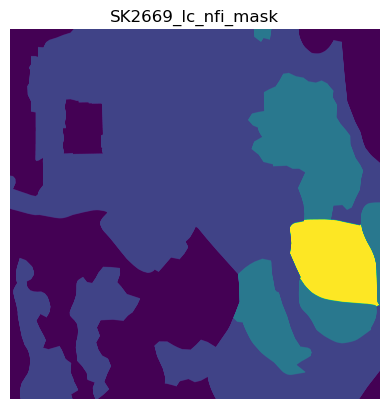

In [42]:
kk += 1
ex_tile = lca.load_tiff(tiff_file_path=list_tifs[kk], datatype='da')
lcv.plot_image_simple(im=ex_tile, name_file=list_tifs[kk].split('/')[-1])
